In [1]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers


# 4 - Assignment Part 2

In [2]:
def mackey_glass(t, mg_dict, beta=0.2, gamma=0.1, n=10, r=25):
    if t == 0:
        return 1.5
    elif t < 0:
        return 0

    if mg_dict.get(t):
        return mg_dict.get(t)

    t_prev = t - 1

    if not mg_dict.get(t_prev):
        mg_dict[t_prev] = mackey_glass(t_prev, mg_dict)

    mg_t = mg_dict.get(t_prev)

    if not mg_dict.get(t_prev - r):
        mg_dict[t_prev - r] = mackey_glass(t_prev - r, mg_dict)

    mg_tr = mg_dict.get(t_prev - r)

    return mg_t + (beta * mg_tr) / (1 + mg_tr ** n) - gamma * mg_t


mg_dict = {}
input = []
output = []
for t in range(300, 1500):
    input.append([mackey_glass(t - 20, mg_dict), mackey_glass(t - 15, mg_dict), mackey_glass(t - 10, mg_dict),
                  mackey_glass(t - 5, mg_dict), mackey_glass(t, mg_dict)])
    output.append(mackey_glass(t + 5, mg_dict))

input = np.array(input)
output = np.array(output)


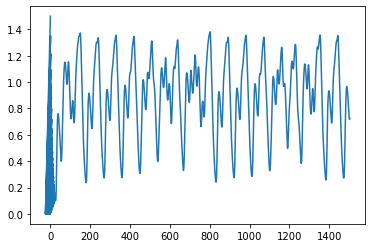

In [3]:
plt.plot(mg_dict.keys(), mg_dict.values())
plt.show()

In [5]:
# consecutive blocks of the time series: train -> val -> test
X_train_val, X_test, y_train_val, y_test = train_test_split(input, output, test_size=200, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)


In [28]:
def create_model(hidden_layer_nodes=[5, 6], input_shape=5, output_shape=1, learning_rate=0.1, momentum=0.5,
                 activation=activations.sigmoid, final_activation=activations.linear,
                 kernel_initializer=initializers.GlorotNormal(),
                 bias_initializer=initializers.Zeros(),
                 regularizer=regularizers.L2(0.0001)):
    model = Sequential()
    for i, nodes in enumerate(hidden_layer_nodes):
        if i == 0:
            print("New input layer:", "input_shape", input_shape, "nodes", nodes)
            model.add(Dense(nodes,
                            input_dim=input_shape,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer,
                            #choose L1 because the weights are not equally important
                            kernel_regularizer=regularizer,
                            bias_regularizer=regularizer))
        else:
            print("New hidden layer:", "nodes", nodes)
            model.add(Dense(nodes,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer,
                            kernel_regularizer=regularizer,
                            bias_regularizer=regularizer))

    print("New output layer:", "output_shape", output_shape)
    model.add(Dense(output_shape,
                    activation=final_activation,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer))

    optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss=losses.mean_squared_error, optimizer=optimizer, metrics=['mse'])
    return model


In [107]:
#lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)
model = create_model()
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)


New input layer: input_shape 5 nodes 9
New hidden layer: nodes 9
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.1639 - mse: 0.1224 - val_loss: 0.0976 - val_mse: 0.0561
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1307 - mse: 0.0892 - val_loss: 0.0966 - val_mse: 0.0552
Epoch 3/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1302 - mse: 0.0888 - val_loss: 0.0964 - val_mse: 0.0551
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1296 - mse: 0.0883 - val_loss: 0.0964 - val_mse: 0.0552
Epoch 5/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1292 - mse: 0.0880 - val_loss: 0.0968 - val_mse: 0.0558
Epoch 6/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1284 - mse: 0.0874 - val_loss: 0.0949 - val_mse: 0.0540
Epoch 7/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1279 - mse: 0.0871 - val_loss: 0.0947 - v

In [8]:
def grid_search(param_dict, _X_train, _y_train, _X_val, _y_val, use_es=True):
    param_grids = list(ParameterGrid(param_dict))
    print(len(param_grids))

    if use_es:
        es = EarlyStopping(monitor='val_mse', mode='min', patience=20, min_delta=0.0001, verbose=1, restore_best_weights=0)
    else:
        es = None
    models = []
    histories = []

    for params in param_grids:
        print(params)
        model = create_model(**params)
        history = model.fit(_X_train, _y_train, validation_data=(_X_val, _y_val), epochs=500, batch_size=10, callbacks=es)
        models.append(model)
        histories.append(history.history)

    final_val_mses = np.around([history['val_mse'][-1] for history in histories], 4)
    final_train_mses = np.around([history['mse'][-1] for history in histories], 4)
    used_epochs = [len(history['val_mse']) for history in histories]
    eval_grid = zip(param_grids, models, histories, final_train_mses, final_val_mses, used_epochs)
    eval_grid = sorted(eval_grid, key=lambda x: x[4])

    for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(eval_grid):
        print(i, final_train_mse, final_val_mse, epoch, param)

    return eval_grid

# Find best hidden layers

In [19]:
nh1 = [3, 4, 5]
nh2 = [2, 4, 6]
layers = [list(items) for items in itertools.product(nh1, nh2)]

param_dict = dict(hidden_layer_nodes=layers)

arch_eval_grid = grid_search(param_dict, X_train, y_train, X_val, y_val)


9
{'hidden_layer_nodes': [3, 2]}
New input layer: input_shape 5 nodes 3
New hidden layer: nodes 2
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 4ms/step - loss: 0.1237 - mse: 0.1225 - val_loss: 0.0609 - val_mse: 0.0597
Epoch 2/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0916 - mse: 0.0904 - val_loss: 0.0636 - val_mse: 0.0625
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0880 - mse: 0.0869 - val_loss: 0.0500 - val_mse: 0.0488
Epoch 4/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0818 - mse: 0.0807 - val_loss: 0.0465 - val_mse: 0.0453
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0737 - mse: 0.0725 - val_loss: 0.0441 - val_mse: 0.0428
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0643 - mse: 0.0630 - val_loss: 0.0353 - val_mse: 0.0340
Epoch 7/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0513 - m

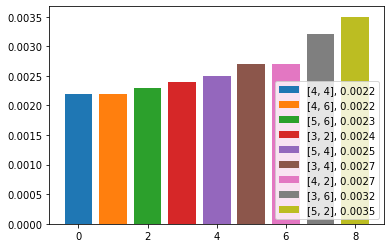

In [26]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(arch_eval_grid):
    h = param["hidden_layer_nodes"]
    plt.bar(i, final_val_mse, label=f"{h}, {final_val_mse}")
plt.legend(loc="lower right")
plt.show()

# Find best regularizer

In [42]:

param_dict = dict(regularizer=[regularizers.L1(0.01),
                               regularizers.L1(0.001),
                               regularizers.L1(0.0001),
                               regularizers.L2(0.01),
                               regularizers.L2(0.001),
                               regularizers.L2(0.0001),
                               regularizers.L1L2(l1=0.01, l2=0.01),
                               regularizers.L1L2(l1=0.001, l2=0.001),
                               regularizers.L1L2(l1=0.0001, l2=0.0001)])

arch_eval_grid = grid_search(param_dict, X_train, y_train, X_val, y_val)


9
{'regularizer': <keras.regularizers.L1 object at 0x000001AB2CABE2B0>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 4
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 4ms/step - loss: 0.2617 - mse: 0.0887 - val_loss: 0.1877 - val_mse: 0.0517
Epoch 2/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1942 - mse: 0.0882 - val_loss: 0.1316 - val_mse: 0.0510
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1512 - mse: 0.0882 - val_loss: 0.1016 - val_mse: 0.0516
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1290 - mse: 0.0887 - val_loss: 0.0860 - val_mse: 0.0543
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1161 - mse: 0.0897 - val_loss: 0.0764 - val_mse: 0.0540
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1069 - mse: 0.0891 - val_loss: 0.0676 - val_mse: 0.0520
Epoch 7/500
80/80 [=========================

In [43]:

for i, (param, model, history, final_val_mse, epoch) in enumerate(arch_eval_grid):
    config = param["regularizer"].get_config()
    print(i, final_val_mse, epoch, config, param)


0 0.002859553787857294 302 {'l1': 9.999999747378752e-05} {'regularizer': <keras.regularizers.L1 object at 0x000001AB2CABE0A0>}
1 0.00430274149402976 247 {'l2': 9.999999747378752e-05} {'regularizer': <keras.regularizers.L2 object at 0x000001AB334A85B0>}
2 0.00478592561557889 306 {'l1': 9.999999747378752e-05, 'l2': 9.999999747378752e-05} {'regularizer': <keras.regularizers.L1L2 object at 0x000001AB334A8220>}
3 0.012700912542641163 142 {'l2': 0.0010000000474974513} {'regularizer': <keras.regularizers.L2 object at 0x000001AB334A8E20>}
4 0.01397428847849369 73 {'l1': 0.0010000000474974513, 'l2': 0.0010000000474974513} {'regularizer': <keras.regularizers.L1L2 object at 0x000001AB334A8DC0>}
5 0.014613157138228416 108 {'l1': 0.0010000000474974513} {'regularizer': <keras.regularizers.L1 object at 0x000001AB2CABE340>}
6 0.05252036452293396 21 {'l1': 0.009999999776482582, 'l2': 0.009999999776482582} {'regularizer': <keras.regularizers.L1L2 object at 0x000001AB334A8280>}
7 0.05394618213176727 22 {

# Evaluate weight initialization best vs worst architecture

In [9]:
layers = [[5, 6], [4, 2]]
param_dict = dict(hidden_layer_nodes=[[5, 6]],
                  kernel_initializer=[initializers.GlorotNormal(),
                                      initializers.HeNormal(),
                                      initializers.RandomNormal(mean=0., stddev=1.),
                                      initializers.Zeros(),
                                      initializers.Ones()]
                  )

weight_eval_grid_best = grid_search(param_dict, X_train, y_train, X_val, y_val)


5
{'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.GlorotNormal object at 0x000001849AB33970>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 6
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 8ms/step - loss: 0.1235 - mse: 0.1211 - val_loss: 0.0533 - val_mse: 0.0509
Epoch 2/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0886 - mse: 0.0862 - val_loss: 0.0556 - val_mse: 0.0532
Epoch 3/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0846 - mse: 0.0821 - val_loss: 0.0513 - val_mse: 0.0488
Epoch 4/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0836 - mse: 0.0811 - val_loss: 0.0586 - val_mse: 0.0561
Epoch 5/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0776 - mse: 0.0750 - val_loss: 0.0450 - val_mse: 0.0424
Epoch 6/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0687 - mse: 0.0661 - val_loss: 0.0372

In [11]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(weight_eval_grid_best):
    config = param["kernel_initializer"].get_config()
    print(i, final_train_mse, final_val_mse, epoch, config, param)


0 0.0026 0.0023 349 {'seed': None} {'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.HeNormal object at 0x000001849C693A30>}
1 0.0031 0.0031 317 {'mean': 0.0, 'stddev': 1.0, 'seed': None} {'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.RandomNormal object at 0x000001849C6934C0>}
2 0.0039 0.0047 191 {'seed': None} {'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.GlorotNormal object at 0x000001849AB33970>}
3 0.0905 0.0591 23 {} {'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.Zeros object at 0x000001849C693C70>}
4 0.1043 0.0626 34 {} {'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.Ones object at 0x000001849C693460>}


In [58]:
layers = [[5, 6], [4, 2]]
param_dict = dict(kernel_initializer=[initializers.GlorotNormal(),
                                      initializers.HeNormal(),
                                      initializers.RandomNormal(mean=0., stddev=1.),
                                      initializers.Zeros(),
                                      initializers.Ones()],
                  hidden_layer_nodes=[[4, 2]],
                  momentum=[0],
                  regularizer=[None],
                  )

weight_eval_grid_worst = grid_search(param_dict, X_train, y_train, X_val, y_val)


5
{'hidden_layer_nodes': [4, 2], 'kernel_initializer': <keras.initializers.initializers_v2.GlorotNormal object at 0x00000184C47602E0>, 'momentum': 0, 'regularizer': None}
New input layer: input_shape 5 nodes 4
New hidden layer: nodes 2
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1294 - mse: 0.1294 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0863 - mse: 0.0863 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 3/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0865 - mse: 0.0865 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0865 - mse: 0.0865 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0860 - mse: 0.0860 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0

In [59]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(weight_eval_grid_worst):
    config = param["kernel_initializer"].get_config()
    print(i, final_train_mse, final_val_mse, epoch, config, param)


0 0.0031 0.003 493 {'seed': None} {'hidden_layer_nodes': [4, 2], 'kernel_initializer': <keras.initializers.initializers_v2.GlorotNormal object at 0x00000184C47602E0>, 'momentum': 0, 'regularizer': None}
1 0.0027 0.0031 425 {'mean': 0.0, 'stddev': 1.0, 'seed': None} {'hidden_layer_nodes': [4, 2], 'kernel_initializer': <keras.initializers.initializers_v2.RandomNormal object at 0x00000184C4AA5D90>, 'momentum': 0, 'regularizer': None}
2 0.0047 0.0076 258 {'seed': None} {'hidden_layer_nodes': [4, 2], 'kernel_initializer': <keras.initializers.initializers_v2.HeNormal object at 0x00000184C4AA5F70>, 'momentum': 0, 'regularizer': None}
3 0.0873 0.0521 24 {} {'hidden_layer_nodes': [4, 2], 'kernel_initializer': <keras.initializers.initializers_v2.Zeros object at 0x00000184C4AA5D60>, 'momentum': 0, 'regularizer': None}
4 0.0883 0.0534 23 {} {'hidden_layer_nodes': [4, 2], 'kernel_initializer': <keras.initializers.initializers_v2.Ones object at 0x00000184C4AA5BB0>, 'momentum': 0, 'regularizer': None

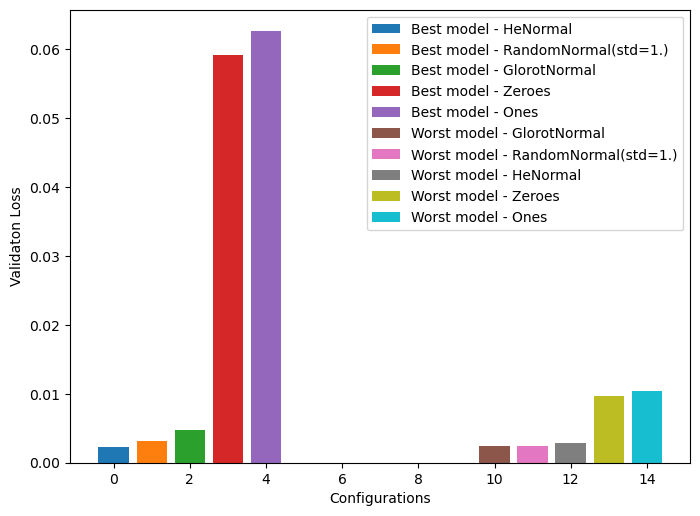

In [41]:
##Plot

names_best = ["HeNormal", "RandomNormal(std=1.)", "GlorotNormal", "Zeroes", "Ones"]
names_worst = ["GlorotNormal", "RandomNormal(std=1.)", "HeNormal", "Zeroes", "Ones"]

plt.figure(figsize=(8, 6), dpi=100)
for i, ((param, model, history, final_train_mse, final_val_mse, epoch), name) in enumerate(zip(weight_eval_grid_best, names_best)):
    plt.bar(i, final_val_mse, label=f"Best model - {name}")
for i, ((param, model, history, final_train_mse, final_val_mse, epoch), name) in enumerate(zip(weight_eval_grid_worst, names_worst)):
    plt.bar(i+10, final_val_mse, label=f"Worst model - {name}")
plt.ylabel("Validaton Loss")
plt.xlabel("Configurations")
plt.legend()
plt.show()


# 3 Evaluate best and worst config

In [46]:
### Best
model_best = create_model()
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
history_best = model_best.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)


perf_best = np.around(model_best.evaluate(X_test, y_test),4)
display(perf_best)
y_pred_best = model_best.predict(X_test)


New input layer: input_shape 5 nodes 5
New hidden layer: nodes 6
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.1063 - mse: 0.1047 - val_loss: 0.0570 - val_mse: 0.0554
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0642 - mse: 0.0625 - val_loss: 0.0431 - val_mse: 0.0412
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0455 - mse: 0.0435 - val_loss: 0.0240 - val_mse: 0.0219
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0360 - mse: 0.0338 - val_loss: 0.0277 - val_mse: 0.0255
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0305 - mse: 0.0282 - val_loss: 0.0234 - val_mse: 0.0211
Epoch 6/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0240 - val_mse: 0.0216
Epoch 7/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0286 - mse: 0.0261 - val_loss: 0.0266 - v

array([0.0153, 0.0118])

7/7 [==============================] - 0s 1000us/step


In [54]:
### Worst
model_worst = create_model(hidden_layer_nodes=[4, 2],
                     momentum=0,
                     kernel_initializer=initializers.RandomNormal(mean=0., stddev=3.))
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
history_worst = model_worst.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)

perf_worst = np.around(model_worst.evaluate(X_test, y_test),4)
display(perf_worst)
y_pred_worst = model_worst.predict(X_test)


New input layer: input_shape 5 nodes 4
New hidden layer: nodes 2
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.2035 - mse: 0.1859 - val_loss: 0.0753 - val_mse: 0.0578
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1015 - mse: 0.0840 - val_loss: 0.0667 - val_mse: 0.0493
Epoch 3/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1009 - mse: 0.0835 - val_loss: 0.0720 - val_mse: 0.0546
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0995 - mse: 0.0822 - val_loss: 0.0638 - val_mse: 0.0466
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0974 - mse: 0.0801 - val_loss: 0.0640 - val_mse: 0.0468
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0772 - val_loss: 0.0684 - val_mse: 0.0513
Epoch 7/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0898 - mse: 0.0727 - val_loss: 0.0548 - v

array([0.0356, 0.02  ])

7/7 [==============================] - 0s 1ms/step


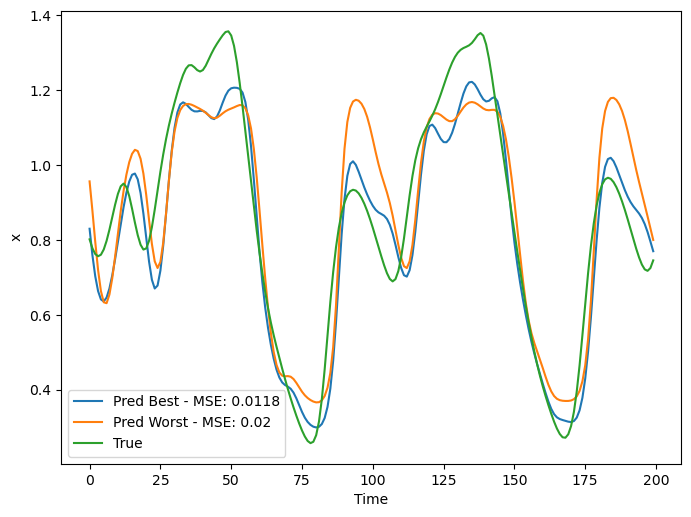

In [56]:
Xrange = range(len(y_pred_best))

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(Xrange, y_pred_best, label=f"Pred Best - MSE: {perf_best[1]}")
plt.plot(Xrange, y_pred_worst, label=f"Pred Worst - MSE: {perf_worst[1]}")
plt.plot(Xrange, y_test, label="True")
plt.ylabel("x")
plt.xlabel("Time")
plt.legend()
plt.show()

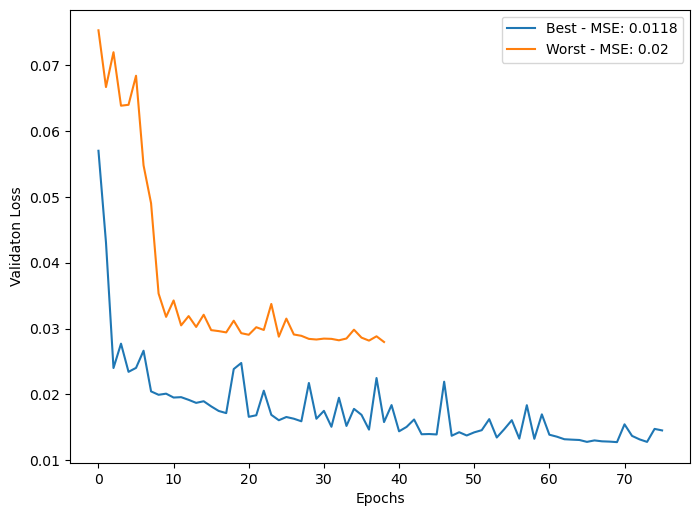

In [57]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history_best.history['val_loss'], label=f"Best - MSE: {perf_best[1]}")
plt.plot(history_worst.history['val_loss'], label=f"Worst - MSE: {perf_worst[1]}")
plt.ylabel("Validaton Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()


# With Noise

In [60]:
def add_gaussian_noise(data, mean=0.0, std=1.0):
    noise = np.random.normal(loc=mean, scale=std, size=data.shape)
    return data + noise


noise_sigma = [0.05, 0.15]

In [61]:
layers = [[5, 3], [5, 6], [5, 9]]
param_dict = dict(hidden_layer_nodes=layers,
                  regularizer=[regularizers.L2(0.1),
                               regularizers.L2(0.01),
                               regularizers.L2(0.001),
                               regularizers.L2(0.0001)]
                  )


In [62]:

X_train_noise_low = add_gaussian_noise(X_train, std=0.05)
y_train_noise_low = add_gaussian_noise(y_train, std=0.05)

X_val_noise_low = add_gaussian_noise(X_val, std=0.05)
y_val_noise_low = add_gaussian_noise(y_val, std=0.05)

noise_low_eval_grid = grid_search(param_dict, X_train_noise_low, y_train_noise_low, X_val_noise_low, y_val_noise_low, use_es=False)


12
{'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x00000184C04EDEE0>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 3
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.3380 - mse: 0.1133 - val_loss: 0.1030 - val_mse: 0.0597
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1359 - mse: 0.0939 - val_loss: 0.1424 - val_mse: 0.1159
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1371 - mse: 0.0961 - val_loss: 0.1014 - val_mse: 0.0570
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1369 - mse: 0.0956 - val_loss: 0.1076 - val_mse: 0.0560
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1372 - mse: 0.0956 - val_loss: 0.1053 - val_mse: 0.0674
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1384 - mse: 0.0969 - val_loss: 0.1048 - val_mse: 0.0665
Epoch 7/500
8

In [63]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(noise_low_eval_grid):
    config = param["regularizer"].get_config()
    print(i, final_train_mse, final_val_mse, epoch, config, param)


0 0.0096 0.011 500 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF66A0>}
1 0.0097 0.0113 500 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF66A0>}
2 0.0097 0.0115 500 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF66A0>}
3 0.0229 0.0205 500 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF6BB0>}
4 0.0214 0.0206 500 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF6BB0>}
5 0.0219 0.0217 500 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF6BB0>}
6 0.0924 0.0554 500 {'l2': 0.009999999776482582} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras

In [64]:

X_train_noise_high = add_gaussian_noise(X_train, std=0.15)
y_train_noise_high = add_gaussian_noise(y_train, std=0.15)

X_val_noise_high = add_gaussian_noise(X_val, std=0.15)
y_val_noise_high = add_gaussian_noise(y_val, std=0.15)

noise_high_eval_grid = grid_search(param_dict, X_train_noise_high, y_train_noise_high, X_val_noise_high, y_val_noise_high, use_es=False)


12
{'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x00000184C04EDEE0>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 3
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.3562 - mse: 0.1424 - val_loss: 0.1605 - val_mse: 0.1315
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1525 - mse: 0.1114 - val_loss: 0.1274 - val_mse: 0.0897
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1531 - mse: 0.1121 - val_loss: 0.1449 - val_mse: 0.1140
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1526 - mse: 0.1120 - val_loss: 0.1230 - val_mse: 0.0810
Epoch 5/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1539 - mse: 0.1128 - val_loss: 0.1231 - val_mse: 0.0812
Epoch 6/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1531 - mse: 0.1121 - val_loss: 0.1226 - val_mse: 0.0781
Epoch 7/500
8

In [65]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(noise_high_eval_grid):
    config = param["regularizer"].get_config()
    print(i, final_train_mse, final_val_mse, epoch, config, param)


0 0.0453 0.0487 500 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF66A0>}
1 0.0453 0.0489 500 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF66A0>}
2 0.0566 0.0523 500 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF6BB0>}
3 0.0459 0.0527 500 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF66A0>}
4 0.0581 0.0547 500 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF6BB0>}
5 0.0561 0.0572 500 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x00000184C9FF6BB0>}
6 0.1141 0.0761 500 {'l2': 0.10000000149011612} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras

7/7 [==============================] - 0s 1ms/step - loss: 0.1265 - mse: 0.1231


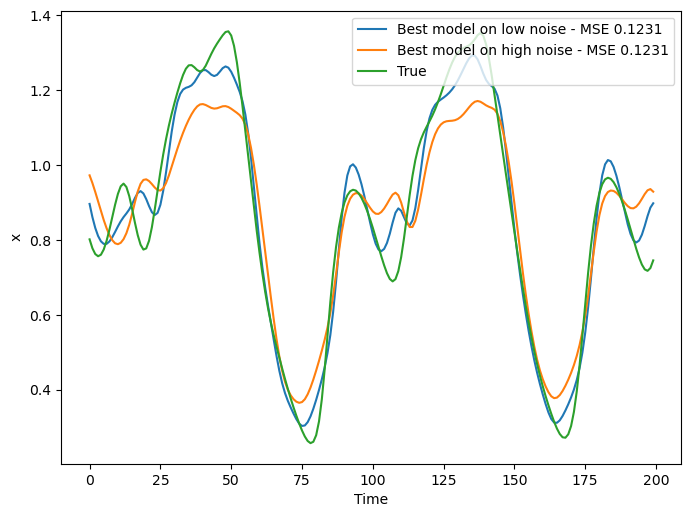

In [66]:
y_pred_lower = noise_low_eval_grid[0][1].predict(X_test)
y_pred_higher = noise_high_eval_grid[0][1].predict(X_test)
Xrange = range(len(y_pred_lower))

plt.figure(figsize=(8, 6), dpi=100)
perf = np.around(model.evaluate(X_test, y_test)[1],4)
plt.plot(Xrange, y_pred_lower, label=f"Best model on low noise - MSE {perf}")
perf = np.around(model.evaluate(X_test, y_test)[1],4)
plt.plot(Xrange, y_pred_higher, label=f"Best model on high noise - MSE {perf}")
plt.plot(Xrange, y_test, label=f"True")
plt.xlabel("Time")
plt.ylabel("x")
plt.legend()
plt.show()

# ??

In [ ]:
layers = [[5, 6]]
param_dict = dict(hidden_layer_nodes=layers,
                  regularizer=[None,
                               regularizers.L2(0.1),
                               regularizers.L2(0.01),
                               regularizers.L2(0.001),
                               regularizers.L2(0.0001)]
                  )

noise_high_eval_grid2 = grid_search(param_dict, X_train_noise_high, y_train_noise_high, X_val_noise_high, y_val_noise_high)


5
{'hidden_layer_nodes': [5, 6], 'regularizer': None}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 6
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 5ms/step - loss: 0.1355 - mse: 0.1355 - val_loss: 0.0920 - val_mse: 0.0920
Epoch 2/500
80/80 [==============================] - 0s 4ms/step - loss: 0.1221 - mse: 0.1221 - val_loss: 0.0992 - val_mse: 0.0992
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1212 - mse: 0.1212 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1201 - mse: 0.1201 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 5/500
80/80 [==============================] - 0s 3ms/step - loss: 0.1186 - mse: 0.1186 - val_loss: 0.0866 - val_mse: 0.0866
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1162 - mse: 0.1162 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 7/500
80/80 [==============================] - 0s 3ms/st

In [ ]:
y_pred_lower_reg = noise_high_eval_grid2[0][1].predict(X_test)
y_pred_higher_reg = noise_high_eval_grid2[1][1].predict(X_test)
Xrange = range(len(y_pred_lower_reg))

plt.figure(figsize=(8, 6), dpi=100)
for (param, model, history, final_train_mse, final_val_mse, epoch) in noise_high_eval_grid2:
    perf = np.around(model.evaluate(X_test, y_test)[1],4)
    try:
        config = param["regularizer"].get_config()
        config = np.around([x for x in config.values()],5)
    except:
        config = "None"
    plt.plot(Xrange, model.predict(X_test), label=f"L2 {config} : MSE {perf}")
plt.plot(Xrange, y_test, label=f"True")
plt.xlabel("Time")
plt.ylabel("x")
plt.legend(loc="lower right")
plt.show()